# Лабораторная работа 2.  
## Линейные модели для классификации
В данной лабораторной работе предлагается реализовать базовый градиентный спуск и его оптимизацию momentum, и сравнить их.

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

plt.rcParams["figure.figsize"] = (20,10)

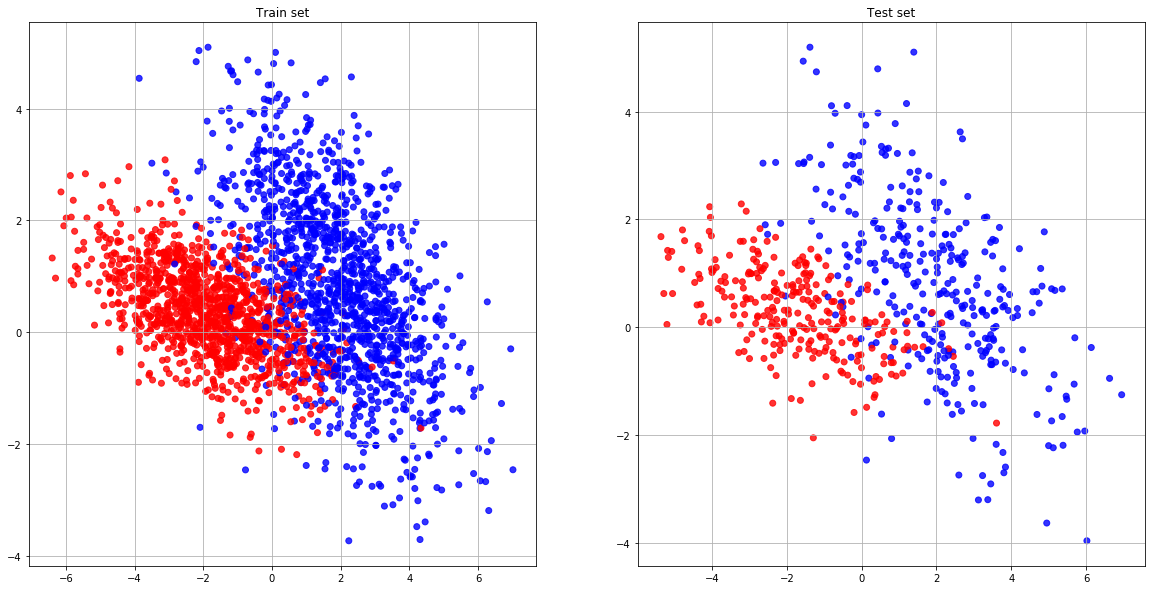

In [7]:
df = pd.read_csv('./2_features/9.csv')
X = df.iloc[:, 0:2].to_numpy()
y = df.iloc[:, 2].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

color_map = {0: 'red', 1: 'blue'}

_, (axs0, axs1) = plt.subplots(1, 2)
axs0.scatter(X_train[:, 0], X_train[:, 1], c=np.vectorize(color_map.get)(y_train), alpha=0.8);
axs0.set_title('Train set')
axs0.grid()

axs1.scatter(X_test[:, 0], X_test[:, 1], c=np.vectorize(color_map.get)(y_test), alpha=0.8);
axs1.set_title('Test set')
axs1.grid()

# Добавим компоненту равную единице.
N_train = X_train.shape[0]
N_test = X_test.shape[0]
X_train = np.hstack((np.ones((N_train, 1)), X_train))
X_test = np.hstack((np.ones((N_test, 1)), X_test))


По графикам видно, что два класса линейно не разделимы. Но один всего лишь незначительно "накладывается" на другой.
Реализуем сразу метод momentum, а базовый градиентный спуск получим из него при $\gamma = 0$.

In [8]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def batch_split(X, y, batch_size):
    data_size = y.size
    if batch_size == -1:
        batch_size = y.size
    
    packs_cnt = int(data_size / batch_size)
    X_batchs = np.array_split(X, packs_cnt)
    y_batchs = np.array_split(y, packs_cnt)
    return X_batchs, y_batchs

def logloss(y, y_pred):
    eps=1e-15
    y_pred = np.clip(y_pred, eps, 1 - eps)
    return -np.dot(y.T, np.log(y_pred)) - np.dot(1 - y.T, np.log(1 - y_pred))

def accuracy(X, y, w):
    y_pred = sigmoid(np.dot(X, w)) >= 0.5
    correct_num = np.count_nonzero(y_pred == y)
    return correct_num / len(y)

def loss(X, y, w):
    y_proba = sigmoid(np.dot(X, w))
    return logloss(y, y_proba)


from sklearn.base import BaseEstimator
from sklearn.utils.multiclass import check_classification_targets
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted


class MomentumMethod(BaseEstimator):
    def __init__(self, l_rate=1e-3, gamma=0.9, epocs=100, batch_size=-1, random_base=42):
        self.l_rate = l_rate
        self.gamma = gamma
        self.epocs = epocs
        self.batch_size = batch_size
        self.random_base = random_base

    
    def fit(self, X, y):
        X, y = check_X_y(X, y)
        check_classification_targets(y)
        
        X_batchs, y_batchs = batch_split(X, y, self.batch_size)
        batch_cnt = len(y_batchs)
        eps = 1e-4
        cnt = 0
        self.used_vecs_ = 0
        self.weights_list_ = np.zeros((batch_cnt * self.epocs, X.shape[1]), dtype=np.float64)
        self.used_vecs_ = np.zeros((batch_cnt * self.epocs, 1), dtype=np.uint32)

        w_i = np.random.RandomState(self.random_base).uniform(-1.0, 1.0, X_batchs[0].shape[1])
        v_prev = np.zeros_like(w_i)
        self.w_ = w_i
        for p_ in range(self.epocs):
            for i in range(batch_cnt):
                y_pred = sigmoid(np.dot(X_batchs[i], self.w_))
                grad = np.dot(X_batchs[i].T, y_pred - y_batchs[i])
                
                v_prev = self.gamma * v_prev - self.l_rate * grad
                self.w_ += v_prev 

                self.weights_list_[cnt] = self.w_
                self.used_vecs_[cnt] = y_pred.size
                cnt += 1

                if np.linalg.norm(grad) <= eps:
                    print(f'Stopped by epsilon on {p_} epoc')
                    self.used_vecs_ = self.used_vecs_[0:cnt]
                    self.weights_list_ = self.weights_list_[0:cnt]
                    return self                

        return self
    
    def predict(self, X):
        check_is_fitted(self, [])
        X = check_array(X)

        y_proba = sigmoid(np.dot(X, self.w_))
        return y_proba >= 0.5
    
    def score(self, X, y):
        correct_num = np.count_nonzero(self.predict(X) == y)
        return correct_num / len(y)

class GradientDescent(MomentumMethod):
    def __init__(self, l_rate=1e-3, epocs=100, batch_size=-1, random_base=42):
        super().__init__(l_rate=l_rate, gamma=0.0, epocs=epocs, batch_size=batch_size, random_base=random_base)


# from sklearn.utils.estimator_checks import check_estimator

# check_estimator(MomentumMethod)
# check_estimator(GradientDescent)

Реализуем вспомогательную функция `get_best_model`, которая с помощью кросс-валидации выбирает лучшую модель с точки зрения точности.
Также функция выводит некоторые характеристики модели

In [5]:
from sklearn.model_selection import GridSearchCV

def get_best_model(estimator, param_grid):

    grid_model = GridSearchCV(estimator, param_grid=param_grid, n_jobs=-1, cv=3)
    grid_model.fit(X_train, y_train)
    best_model = grid_model.best_estimator_

    print(f'Best params: {grid_model.best_params_}')
    print(f'Logloss: {loss(X_train, y_train, best_model.w_)}')
    print(f'Train accuracy: {best_model.score(X_train, y_train)}')
    print(f'Test accuracy: {best_model.score(X_test, y_test)}')
    
    w0, w1, w2 = best_model.w_
    print(f'Line equation: y = {-w1 / w2} * x + {-w0 / w2}')
    
    return best_model

## Vanilla Gradient Descent (VGD) 
`batch_size = -1`, т.е. градиент считается сразу для всего тренировочного набора.

Для `VGD` и остальных методов будем строить модели следующим образом:
* Сначала будем подбирать параметр $\alpha$ для модели, которая использует базовый градиентный спуск.
* Затем будем использовать подобранный $\alpha$ для модели, которая использует `momentum`, и будем подбирать $\gamma$.
* Наконец, будем брать подобранный $\alpha$ и $\gamma = 0.9$.

In [6]:
params = {
    'l_rate': np.geomspace(1e-4, 1e-1, 10)
}

vgd_model = get_best_model(GradientDescent(epocs=100, batch_size=-1), params)

Best params: {'l_rate': 0.001}
Logloss: 432.55749905951495
Train accuracy: 0.9274697790746145
Test accuracy: 0.9216666666666666
Line equation: y = -1.1896127331524238 * x + 0.519304922907262


In [7]:
params = {
    'gamma': np.arange(0.1, 1.0, 0.1)
}

momentum_vgd_model = get_best_model(MomentumMethod(epocs=100, batch_size=-1, l_rate=vgd_model.l_rate), params)
momentum_vgd_model_09 = get_best_model(MomentumMethod(epocs=100, batch_size=-1, l_rate=vgd_model.l_rate), {'gamma': [0.9]})

Best params: {'gamma': 0.1}
Logloss: 432.55708418170786
Train accuracy: 0.9274697790746145
Test accuracy: 0.9216666666666666
Line equation: y = -1.1893143656970648 * x + 0.51949700859016
Best params: {'gamma': 0.9}
Logloss: 432.56145202127567
Train accuracy: 0.9274697790746145
Test accuracy: 0.9216666666666666
Line equation: y = -1.187216535341947 * x + 0.5200793737053456


Как видим, все модели получили почти одинаковые значения функции ошибки и точности на тренировочных и тестовых данных.

## Stochastic gradient descent (SGD)
`batch_size = 1`, т.е. градиент пересчитывается для каждого тестового вектора.

In [8]:
params = {
    'l_rate': np.geomspace(1e-4, 1e-1, 10)
}

sgd_model = get_best_model(GradientDescent(epocs=100, batch_size=1), params)

Stopped by epsilon on 3 epoc
Best params: {'l_rate': 0.004641588833612777}
Logloss: 438.4425805914364
Train accuracy: 0.9266360983743226
Test accuracy: 0.925
Line equation: y = -1.2467543433567945 * x + 0.46014465501986035


In [9]:
params = {
    'gamma': np.arange(0.1, 1.0, 0.1)
}

momentum_sgd_model = get_best_model(MomentumMethod(epocs=100, batch_size=1, l_rate=sgd_model.l_rate), params)
momentum_sgd_model_09 = get_best_model(MomentumMethod(epocs=100, batch_size=1, l_rate=sgd_model.l_rate), {'gamma': [0.9]})

Stopped by epsilon on 2 epoc
Best params: {'gamma': 0.4}
Logloss: 439.60225673231616
Train accuracy: 0.9258024176740308
Test accuracy: 0.925
Line equation: y = -1.283196211116857 * x + 0.44926434298159024
Stopped by epsilon on 0 epoc
Best params: {'gamma': 0.9}
Logloss: 444.25230855970165
Train accuracy: 0.924968736973739
Test accuracy: 0.9183333333333333
Line equation: y = -1.3773353553797238 * x + 0.3535476850918396


Как видим, немного отличаются значения функции ошибки, но точности на тренировочных данных равны до 3-х знаков.
Стоит отметить, что значения градиента очень быстро становится равным нулю и метод выходит по критерию.
## Mini-bacth gradient descent (MBGD)
`batch_size = N`, где `N` меньше количества тренировочных данных.
Выберем `batch_size = 32`, как советуют некоторые иследователи.

In [10]:
params = {
    'l_rate': np.geomspace(1e-4, 1e-1, 10),
}

mbgd_model = get_best_model(GradientDescent(epocs=100, batch_size=32), params)

Best params: {'l_rate': 0.001}
Logloss: 432.5583865362271
Train accuracy: 0.9274697790746145
Test accuracy: 0.9216666666666666
Line equation: y = -1.1912812071849284 * x + 0.5189740416022985


In [11]:
params = {
    'gamma': np.arange(0.1, 1.0, 0.1)
}

momentum_mbgd_model = get_best_model(MomentumMethod(epocs=100, batch_size=32, l_rate=mbgd_model.l_rate), params)
momentum_mbgd_model_09 = get_best_model(MomentumMethod(epocs=100, batch_size=32, l_rate=mbgd_model.l_rate), {'gamma': [0.9]})

Best params: {'gamma': 0.1}
Logloss: 432.5579324457711
Train accuracy: 0.9274697790746145
Test accuracy: 0.9216666666666666
Line equation: y = -1.1911343002900974 * x + 0.5193206777249049
Best params: {'gamma': 0.9}
Logloss: 432.57083528605835
Train accuracy: 0.9274697790746145
Test accuracy: 0.92
Line equation: y = -1.194506814178604 * x + 0.525868151907323


Здесь значения функции ошибки и значения точности почти идентичны. 
## Графическое сравнение
Будем сравнивать скорости сходимости методов. Для этого будем строить график зависимости ошибки, точности на тестовых и тренировочных данных в зависимости от количества использованных векторов.

In [12]:
def get_errors(weights, X, y):
    errors = np.empty((weights.shape[0]))
    for i in range(errors.size):
        y_pred = sigmoid(np.dot(X, weights[i]))
        errors[i] = logloss(y, y_pred)

    return errors
    
def plot_stats(estimator, legend_str, plotting_grid):
    def help_plot(ax, title, xlabel, ylabel):
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.legend()
        ax.grid()

    uv = np.cumsum(estimator.used_vecs_)
    print('Used vectors: ', uv[-1])
    weights = estimator.weights_list_
    errors = get_errors(weights, X_train, y_train)
    
    acc_train = [accuracy(X_train, y_train, w) for w in weights]
    acc_test = [accuracy(X_test, y_test, w) for w in weights]
    
    ax0, ax1, ax2 = plotting_grid    
    ax0.plot(uv, errors, label=legend_str)
    help_plot(ax0, 'Error function', 'used vecs', 'LogLoss function')

    ax1.plot(uv, acc_train, label=legend_str)
    help_plot(ax1, 'Train accuracy', 'used vecs', 'Train accuracy')
    acc_train_min, acc_train_max = np.min(acc_train), np.max(acc_train)
    ax1.set_ylim([acc_train_min - 0.01, acc_train_max + 0.01])
    
    ax2.plot(uv, acc_test, label=legend_str)
    help_plot(ax2, 'Test accuracy', 'used vecs', 'Test accuracy')
    acc_test_min, acc_test_max = np.min(acc_test), np.max(acc_test)
    ax2.set_ylim([acc_test_min - 0.01, acc_test_max + 0.01])
    
    return {'uv': uv, 'errs': errors, 'gamma': estimator.gamma}

## Сходимость базового градиентного спуска

Used vectors:  8783
Used vectors:  239900
Used vectors:  239900


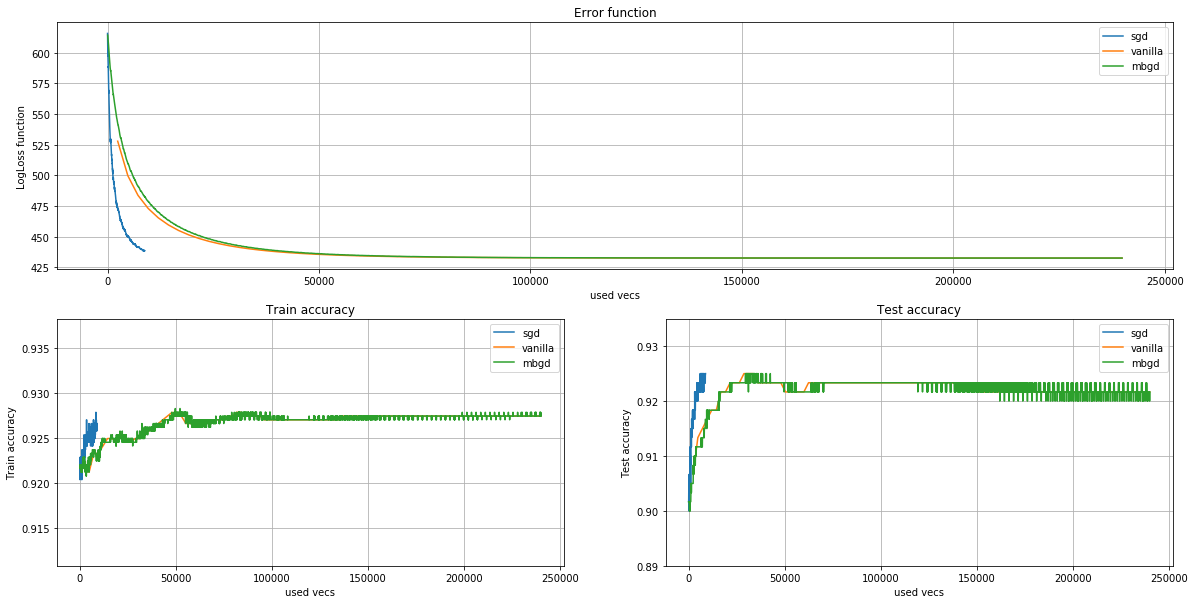

In [13]:
plotting_grid = [plt.subplot(211), plt.subplot(223), plt.subplot(224)]

sgd_ps = plot_stats(sgd_model, 'sgd', plotting_grid)
vgd_ps = plot_stats(vgd_model, 'vanilla', plotting_grid)
mbgd_ps = plot_stats(mbgd_model, 'mbgd', plotting_grid)

Из графиков видно, что все методы уже за первую итерацию достигают точности порядка 90%. 
Это можно объяснить тем, что данные очень близки к линейному разделению.
### SGD
Стохастический градиент показывает очень быструю сходимость! 
Но, даже на таком масштабе видно, что значения функции потерь очень зашумлено при спуске.
Это можно объяснить тем, что учитывается вклад от каждого тестового вектора, что позволяет не попасть в локальный минимум и попасть в хороший глобальный минимум.

### VGD
Обычный градиентный спуск плох тем, что он может попасть в локальный минимум, так как он сразу учитывает все тестовые данные.
Но данный метод с вычислительной точки зрения работает быстро, т.к. поддается параллелизации.

### MBGD
Данный метод является некоторым компромиссом между `SGD` и `VGD`, так как менее подвержен "сваливанию" в локальный минимум, чем VGD, но его тоже можно считать параллельно.
Обычно данный метод быстрее сходится, чем `VGD`, но в данном случае он показывает такую же скорость сходимости, что и `VGD`.
Наблюдается некаю зашумленность метрик точности. Но данные колебания незначительны, $\pm 0.01$.

## Сходимость оптимизации `momentum` с подобранным $\gamma$

Used vectors:  4854
Used vectors:  239900
Used vectors:  239900


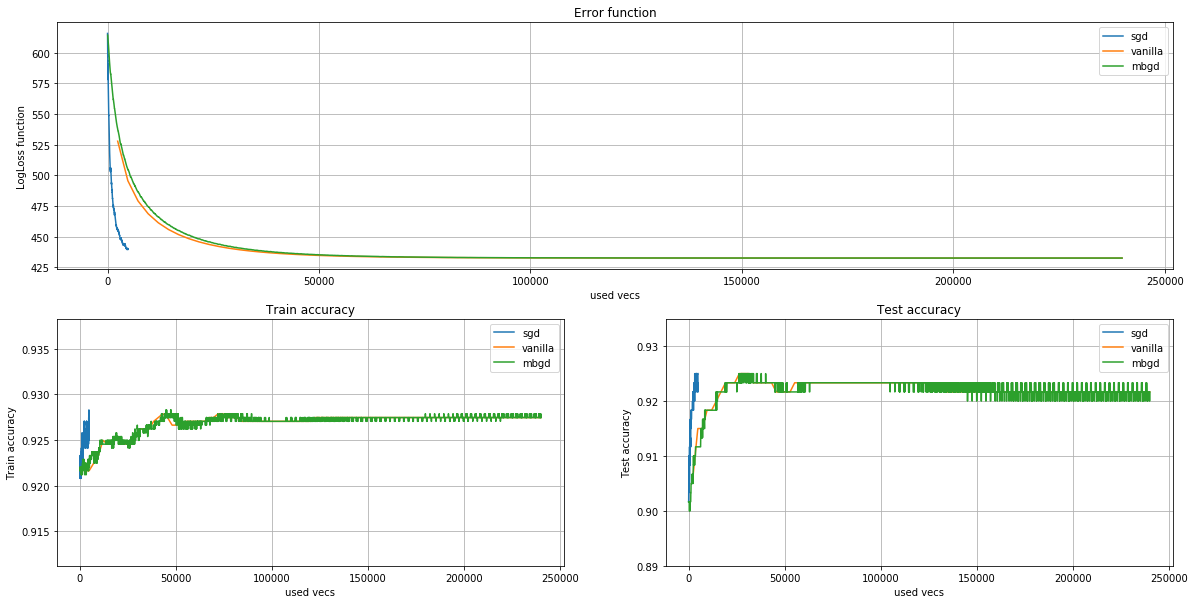

In [14]:
plotting_grid = [plt.subplot(211), plt.subplot(223), plt.subplot(224)]

mm_sgd_ps = plot_stats(momentum_sgd_model, 'sgd', plotting_grid)
mm_vgd_ps = plot_stats(momentum_vgd_model, 'vanilla', plotting_grid)
mm_mbgd_ps = plot_stats(momentum_mbgd_model, 'mbgd', plotting_grid)

Для значения $\gamma$, подобранного с помощью кросс-валидации, на данных графиках не видно улучшений по сравнению с базовым градиентным спуском.

## Сходимость оптимизации `momentum` с подобранным $\gamma = 0.9$

Used vectors:  568
Used vectors:  239900
Used vectors:  239900


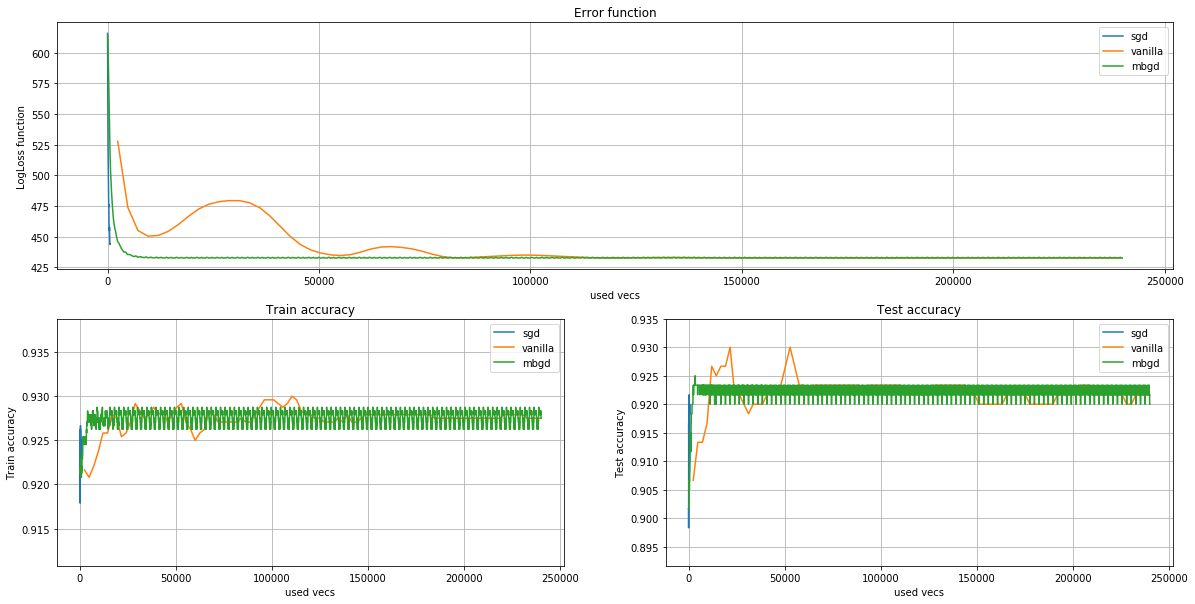

In [15]:
plotting_grid = [plt.subplot(211), plt.subplot(223), plt.subplot(224)]

mm_sgd_09_ps = plot_stats(momentum_sgd_model_09, 'sgd', plotting_grid)
mm_vgd_09_ps = plot_stats(momentum_vgd_model_09, 'vanilla', plotting_grid)
mm_mbgd_09_ps = plot_stats(momentum_mbgd_model_09, 'mbgd', plotting_grid)

Для $\gamma = 0.9$ видно, что `SGD` стал сходиться еще быстрее, `VGD` стал долго сходиться, а `MBGD` смог значительно обогнать `VBGD` и приблизился к `SGD`.
## Сравнения методов при разных $\gamma$
# SGD

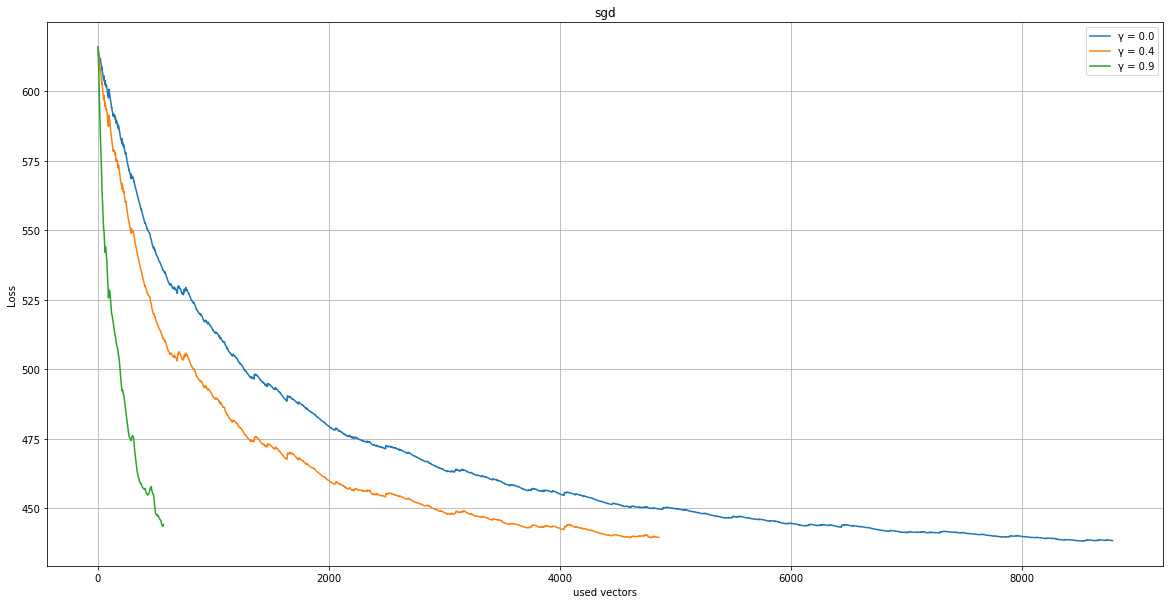

In [17]:
def compare_models(models_params, name):
    for params in models_params:
        label = '\u03B3 = ' + str(params['gamma'])
        plt.plot(params['uv'], params['errs'], label=label)
    
    plt.xlabel('used vectors')
    plt.ylabel('Loss')
    plt.title(name)
    plt.grid()
    plt.legend()

compare_models([sgd_ps, mm_sgd_ps, mm_sgd_09_ps], 'sgd')

Как видим, в данном случае метод `momentum` значительно помогает ускорить сходимость.
При $\gamma = 0.9$ метод вышел по критерию еще на первой эпохе, не пройдя все тренировочные данные.
# VGD

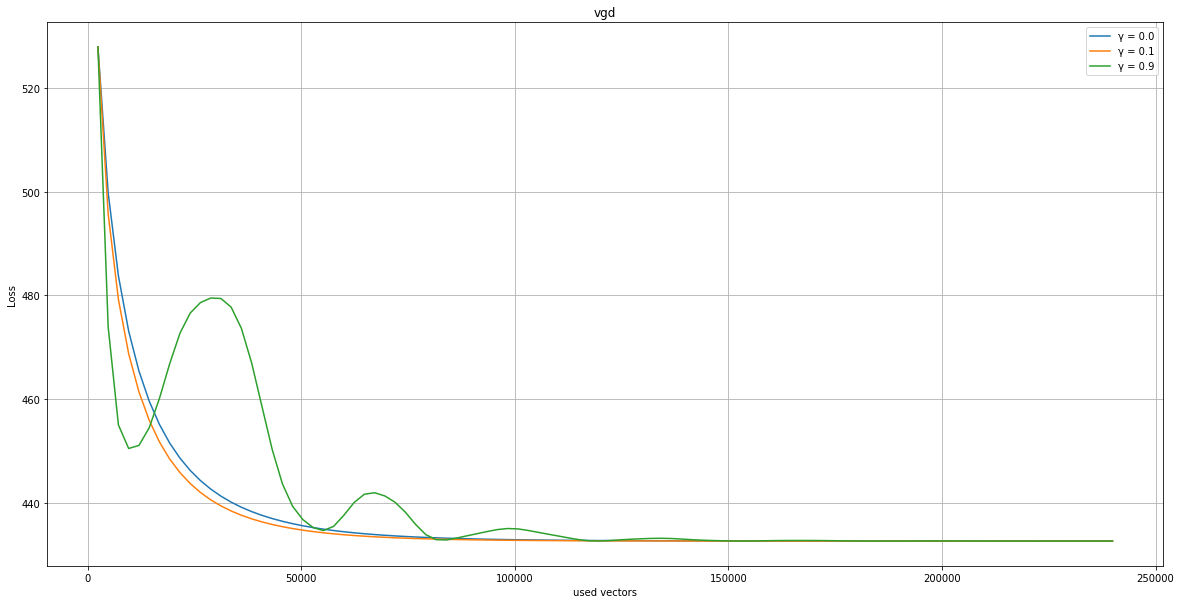

In [18]:
compare_models([vgd_ps, mm_vgd_ps, mm_vgd_09_ps], 'vgd')

Как видим, при $\gamma = 0.1$ скорость сходимости увеличилась незначительно.
А при $\gamma = 0.9$, видимо, вначале метод начал сходиться в локальный минимум, а затем его "сорвало" и потребовалось много эпох, чтобы прийти в глобальный минимум.
# MBGD

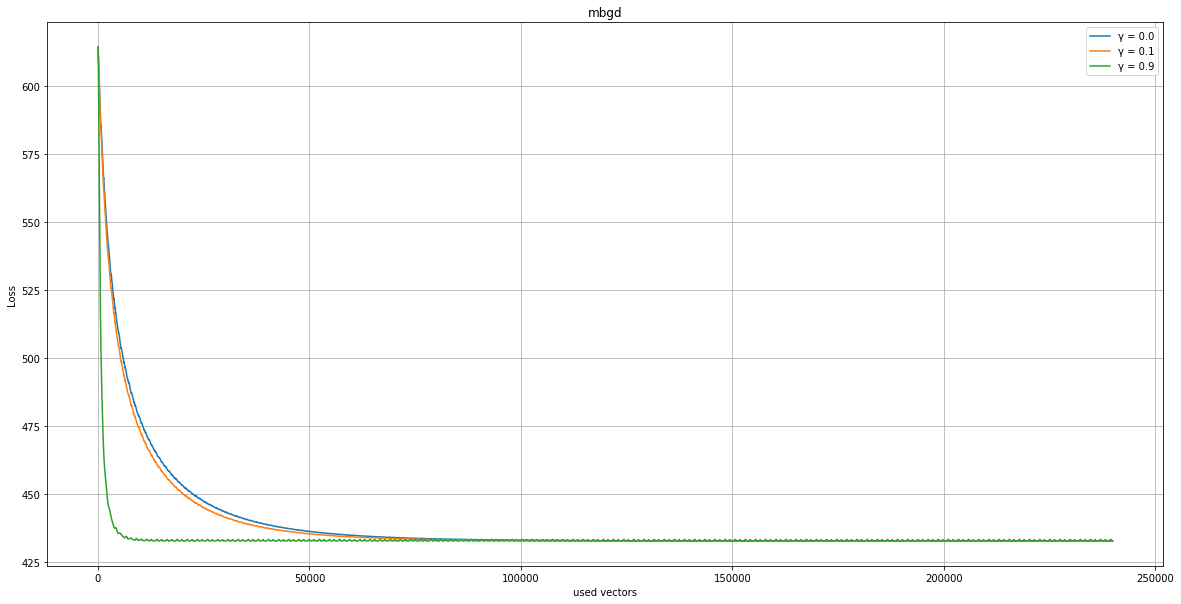

In [19]:
compare_models([mbgd_ps, mm_mbgd_ps, mm_mbgd_09_ps], 'mbgd')

Как видим, при $\gamma = 0.1$ скорость сходимости увеличилась незначительно.
При $\gamma = 0.9$ метод очень быстро пришел к глобальному минимуму, но, судя по шуму, появились маленькие "блуждания" вокруг точки минимума.
# График разделения на признаки

Line equation: y = -1.190 * x + 0.519


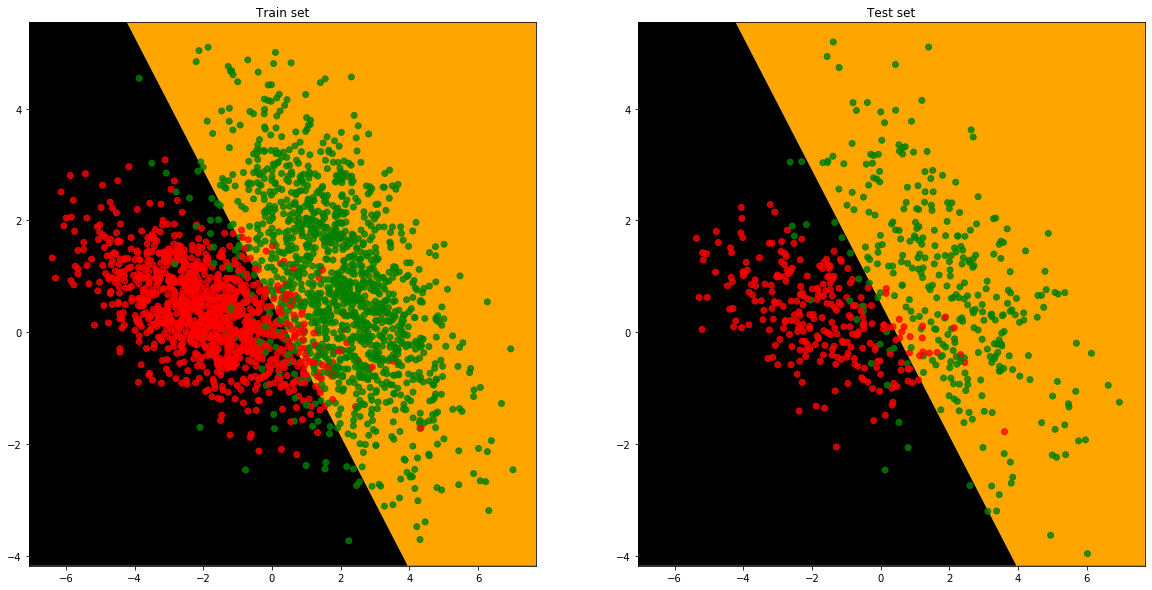

In [64]:
color_map = {0: 'red', 1: 'green'}

_, (axs0, axs1) = plt.subplots(1, 2)
axs0.scatter(X_train[:, 1], X_train[:, 2], c=np.vectorize(color_map.get)(y_train), alpha=0.8);
axs0.set_title('Train set')
left_x, right_x = axs0.get_xlim()
left_y, right_y = axs0.get_ylim()

axs1.scatter(X_test[:, 1], X_test[:, 2], c=np.vectorize(color_map.get)(y_test), alpha=0.8);
axs1.set_title('Test set')
axs1.set_xlim([left_x, right_x])
axs1.set_ylim([left_y, right_y])

w0, w1, w2 = vgd_model.w_
xx = np.array([left_x, right_x])
yy = (-w1 / w2) * xx + (-w0 / w2)
print(f'Line equation: y = {-w1/w2:.3f} * x + {-w0/w2:.3f}')

axs0.fill_between(xx, yy, right_y, fc='orange');
axs0.fill_between(xx, yy, left_y, fc='black');
axs0.scatter(X_train[:, 1], X_train[:, 2], c=np.vectorize(color_map.get)(y_train), alpha=0.8);
axs0.set_xlim([left_x, right_x]);
axs0.set_ylim([left_y, right_y]);

axs1.fill_between(xx, yy, right_y, fc='orange');
axs1.fill_between(xx, yy, left_y, fc='black');
axs1.scatter(X_test[:, 1], X_test[:, 2], c=np.vectorize(color_map.get)(y_test), alpha=0.8);
axs1.set_xlim([left_x, right_x]);
axs1.set_ylim([left_y, right_y]);

Видим, что разделяющая поверхность (в данном случае - линия) - линейная.

## Вывод
Все методы показали себя достаточно хорошо, так как данные близки к линейному разделению.
Можно сделать вывод, что иногда сложно подобрать правильные параметры модели.
Но при грамотном подборе параметров, можно получить модель, которая очень быстро сходится к глобальному минимуму.